Text(0.5, 1.0, '극단이상값 제거 전 숙박요금의 상자그림')

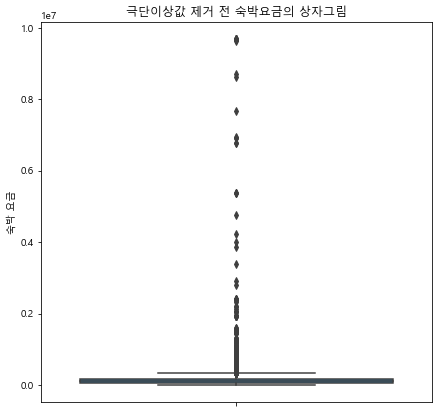

In [365]:
# 모듈 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import json   
import datetime
import folium
from haversine import haversine

# 판다스 기본설정
pd.set_option('display.max_columns', None)

# 그래프 출력 설정
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# data 불러오기
df = pd.read_csv("data/listings.csv")

# 모든 값이 결측값인 변수 제거
df = df.drop(columns = df.columns[df.isna().sum() == len(df)].tolist())

# 자료형 변환

# 숫자형으로 저장된 범주형 변수 문자형으로 변환
df["id"] = df["id"].apply(lambda x : str(x))
df["host_id"] = df["host_id"].apply(lambda x : str(x))
df["scrape_id"] = df["scrape_id"].apply(lambda x : str(x))


# 시간형 변수들의 자료형 변환 (object to datetime)
to_datetime_columns= ["last_scraped", "host_since", "calendar_last_scraped", "first_review", "last_review"]
for column in to_datetime_columns:
    df[column] = pd.to_datetime(df[column])
del to_datetime_columns    

# 응답률의 퍼센트 단위제거
remove_percent_columns = ["host_response_rate", "host_acceptance_rate"]
for column in remove_percent_columns:
    df[column] = df[column].apply(lambda x : x if x is np.nan else int(x.replace("%", ""))/100)
del remove_percent_columns    

# 가격의 ($)와 콤마 제거
df["price"] = df["price"].apply(lambda x : float(x[1:].replace(",", "")))

# 가격의 단위 한화로 수정 (2022.04.29 20:00 기준 엔화 -> 한화)
df["price"] = df["price"].apply(lambda x : int(x * 9.679))

# 이상치 확인
plt.figure(figsize=(7,7))
ax = sns.boxplot(y ="price", data=df)
ax.set(ylabel='숙박 요금')
ax.set_title("극단이상값 제거 전 숙박요금의 상자그림")

숙소의 가격이 511178.0원 이상인 숙소는 제거


Text(0.5, 1.0, '극단이상값 제거후 숙박 요금의 상자그림')

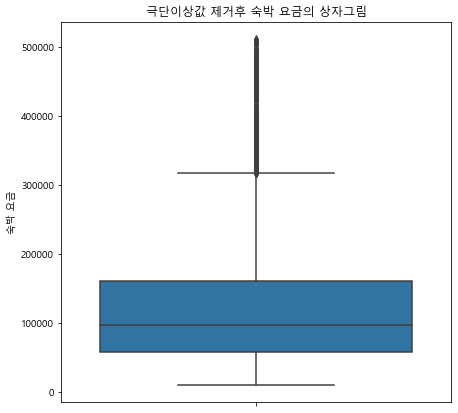

In [366]:
# 이상치 제거

# 숙소의 가격이 0 인 경우 제거
df = df[df["price"]!=0]

# 숙소의 가격 극단 이상값 제거 (Q3 에서 2 step 이상인 값 제거)
IQR = (df["price"].describe()["75%"] - df["price"].describe()["25%"]) * 1.5
print(f"숙소의 가격이 {df['price'].describe()['75%'] + 2 * IQR}원 이상인 숙소는 제거")
df = df[df["price"] < df["price"].describe()["75%"] + 2 * IQR]

# bathrooms_text 변수가 결측값인 38개의 case 제거
df = df.dropna(subset="bathrooms_text")

# 인덱스 초기화
df = df.reset_index(drop = True)

# 이상치 제거후 숙박 요금의 상자그림
plt.figure(figsize=(7,7))
ax = sns.boxplot(y ="price", data=df)
ax.set(ylabel='숙박 요금')
ax.set_title("극단이상값 제거후 숙박 요금의 상자그림")

In [367]:
# 지역별 숙소의 개수 시각화
latitude, longitude = (35.72182255318591, 139.53801614242826)
map_tokyo = folium.Map(location=[latitude, longitude], 
                zoom_start=10)
with open("data/summary_file/neighbourhoods.geojson",'r') as json_file:             
    tokyo_geo = json.load(json_file)

folium.GeoJson(
    tokyo_geo,
    name='지역구'
).add_to(map_tokyo)

tokyo_group_data = df.groupby("neighbourhood_cleansed").count()["id"]

map_tokyo.choropleth(geo_data=tokyo_geo,
             data=tokyo_group_data, 
             fill_color='YlOrRd', # 색상 변경도 가능하다
             fill_opacity=0.5,
             line_opacity=0.2,
             key_on="properties.neighbourhood",
             legend_name= "숙소의 개수"
            )

map_tokyo

C:\Users\havea\anaconda3\envs\cp1\lib\site-packages\folium\folium.py:409: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


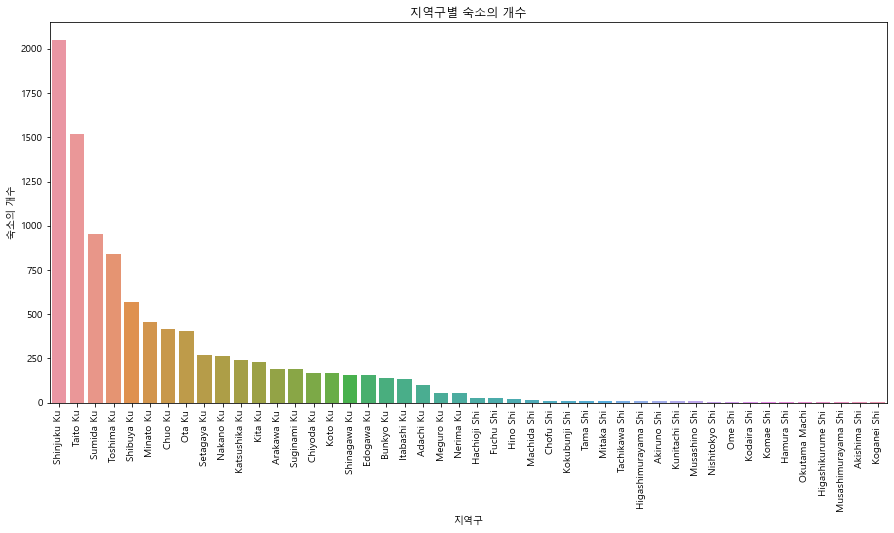

In [368]:
# 지역별 숙소의 개수 시각화 (수평 막대그래프)
neighbourhood_count = pd.DataFrame(tokyo_group_data).reset_index()
neighbourhood_count = neighbourhood_count.sort_values(by="id", ascending=False)
plt.figure(figsize=(15,7))
ax = sns.barplot(y= "id", x = "neighbourhood_cleansed",  data = neighbourhood_count)
ax.set(ylabel='숙소의 개수', xlabel='지역구')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_title("지역구별 숙소의 개수")
plt.show()

In [369]:
# 도쿄도 23구 가 아닌 시들은 데이터가 너무 적음 분석에서 제외
df["is_Ku"] = df["neighbourhood_cleansed"].apply(lambda x : True if "Ku" == x.split()[1] else False)
df = df[df["is_Ku"]]

# 23구의 지역 정보만 따로 저장
with open("data/summary_file/neighbourhoods.geojson",'r') as json_file:             
    tokyo_geo = json.load(json_file)

tokyo_geo_23_Ku = {}
tokyo_geo_23_Ku["type"] = 'FeatureCollection'

features_list = []
for i in tokyo_geo["features"]:
    if i["properties"]["neighbourhood"].split()[1] == "Ku":
        features_list.append(i)
    else:
        pass

tokyo_geo_23_Ku["features"] = features_list

In [370]:
# 특성공학

# 공용화장실이면 1 아니면 0 으로 변수 생성
def shared_bathrooms(x):
    if ("shared" in x.lower()) or (x == "0 baths"):
        return 1
    else:
        return 0
df["shared_bathrooms"] = df["bathrooms_text"].apply(shared_bathrooms)

# 편의시설 정보 가공
df["amenities"] = df["amenities"].apply(lambda x : json.loads(x))
df["amenities"] = df["amenities"].apply(lambda x : list(map(lambda amm_str : amm_str.lower() , x)))

# 편의시설의 개수 
df["no_of_amenities"] = df["amenities"].apply(lambda x : len(x))


def amenities(x):
    amenities_list = []
    for i in df["amenities"]:
        amenities_list += i
    amenities_list = list(set(amenities_list))
    output = []
    for i in amenities_list:
        if x in i:
            output.append(i)
    return output
tv_list = amenities("tv")
wifi_list = amenities("wifi")
dryer_list = amenities("dryer")
dryer_list.remove('hair dryer')
refrigerator_list = amenities("refrigerator")

# 숙소의 TV 보유 여부
df["tv"] = df["amenities"].apply(lambda x : 1 if True in [i in tv_list for i in x] else 0)

# 숙소의 wifi 보유 여부
df["wifi"] = df["amenities"].apply(lambda x : 1 if True in [i in wifi_list for i in x] else 0)

# 숙소의 건조기 보유 여부
df["dryer"] = df["amenities"].apply(lambda x : 1 if True in [i in dryer_list for i in x] else 0)

# 숙소의 냉장고 보유 여부
df["refrigerator"] = df["amenities"].apply(lambda x : 1 if True in [i in refrigerator_list for i in x] else 0)

# 위의 4가지중 편의시설중 가지고있는 것의 개수
df["full_option"] = df["tv"] + df["wifi"] + df["dryer"] + df["refrigerator"]

# 풀옵션 여부
df["is_full_option"] = df["full_option"].apply(lambda x : 1 if x == 4 else 0)

# 10명이상 수용하는 숙소는 일괄 10으로 변경해준다.
df["accommodates"] = df["accommodates"].apply(lambda x : x if x < 10 else 10)

In [371]:
# 구와 4가지 대표 편의시설, 화장실의 공유 여부, 숙소의 수용인원중에서 숙박요금에 유의한 영향을 주는 변수만 사용하도록 한다.
# 너무 조건이 세분화되면 표본의 개수가 많이 줄어들어서 검정력이 많이 낮아질 수 있다.
new_col = ["tv", "wifi", "refrigerator", "dryer", "accommodates", "price", "neighbourhood_cleansed", "shared_bathrooms"]
df = df[new_col]

# 가설 : 구별로 숙소의 평균 가격의 차이가 있다.

# 23구별 숙소의 평균가격 시각화
latitude, longitude = 35.68333221633855, 139.7653272944707
map_tokyo = folium.Map(location=[latitude, longitude], 
                zoom_start=11)
with open("data/summary_file/neighbourhoods.geojson",'r') as json_file:             
    tokyo_geo = json.load(json_file)

folium.GeoJson(
    tokyo_geo_23_Ku,
    name='지역구'
).add_to(map_tokyo)

tokyo_group_data = df.groupby("neighbourhood_cleansed").mean()["price"]
bins = list(tokyo_group_data.quantile([0, 0.25, 0.5, 0.75, 1]))
map_tokyo.choropleth(geo_data=tokyo_geo_23_Ku,
             data=tokyo_group_data, 
             fill_color='YlOrRd', 
             fill_opacity=0.5,
             line_opacity=0.2,
             key_on="properties.neighbourhood",
             legend_name= "숙소의 평균 가격",
             bins = bins
            )

map_tokyo

C:\Users\havea\anaconda3\envs\cp1\lib\site-packages\folium\folium.py:409: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


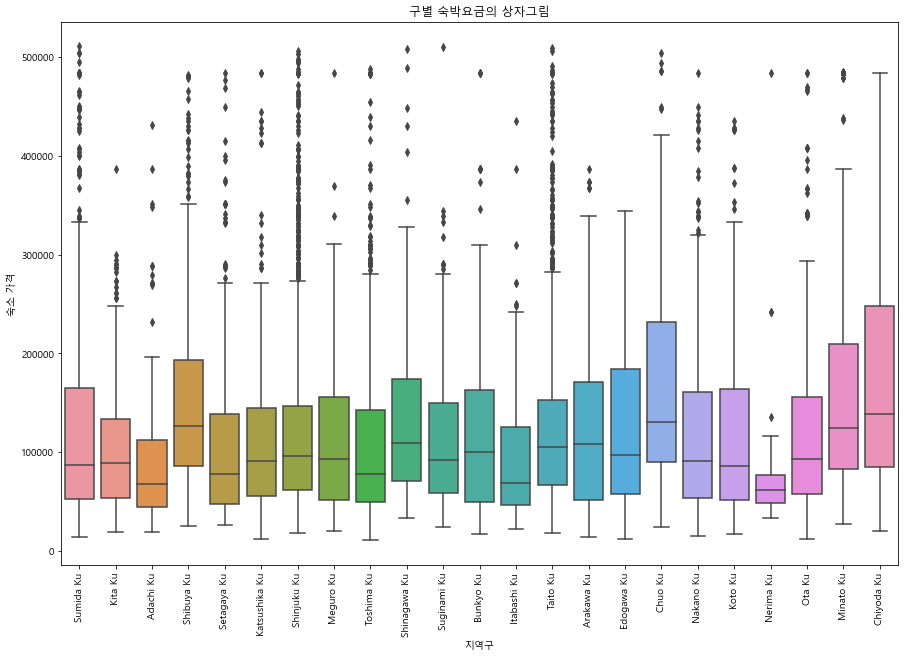

In [372]:
# 구별 숙박요금의 상자그림
neighbourhood_count = pd.DataFrame(tokyo_group_data).reset_index()
neighbourhood_count = neighbourhood_count.sort_values(by="price", ascending=False)
plt.figure(figsize=(15,10))
ax = sns.boxplot(y= "price", x = "neighbourhood_cleansed",  data = df)
ax.set(xlabel='지역구', ylabel='숙소 가격')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_title("구별 숙박요금의 상자그림")
plt.show()

In [373]:
# 상자그림으로 보아 정규성과 등분산성에 문제가 있을수 있다고 판단
# 등분산검정 실시
Ku_list = list(df["neighbourhood_cleansed"].value_counts().index)
data_ = [df.loc[df["neighbourhood_cleansed"] == Ku, "price"].values for Ku in Ku_list]
stats.levene(*data_)
# 등분산 검정의 귀무가설을 기각한다 즉, 등분산이 아니다

LeveneResult(statistic=7.107557836830663, pvalue=4.807019150747274e-22)

In [374]:
# 등분산이 아니므로 이분산에 강건한 Welch anova 실시
import pingouin as pg
pg.welch_anova(dv='price', between='neighbourhood_cleansed', data=df)
# 귀무가설을 기각한다 지역구별로 숙소 가격의 평균에 차이가 있다.

,Source,ddof1,ddof2,F,p-unc,np2
0,neighbourhood_cleansed,22,1439.181425,13.346841,2.188539e-44,0.032699


In [375]:
# 사후검정 실시
post_hoc = pg.pairwise_gameshowell(dv='price', between='neighbourhood_cleansed', data=df)
vis = pd.pivot_table(post_hoc,values="pval",index="A",columns="B")
columns_list = list(vis.columns)
temp_list = [np.NAN] * vis.shape[0]
vis["Adachi Ku"] = temp_list
vis = vis [["Adachi Ku"] + columns_list]
temp_df = pd.DataFrame([np.NAN]*(vis.shape[1])).T
temp_df.columns = vis.columns
vis = pd.concat([vis, temp_df], axis=0)
vis = vis.rename(index={0 : "Toshima Ku"})# >= 0.05

# 서로 다른 구를 입력하면 유의확률을 반환해주는 함수
def is_significant_pval(area1, area2):
    if area1 == area2:
        raise "서로 다른 지역을 입력하시오"
    else:
        if pd.isna(vis.loc[area1, area2]):
            return vis.loc[area2, area1]        
        else:
            return vis.loc[area1, area2]

# 서로 다른 구를 입력하면 평균의 차이가 유의한지 알려주는 함수
def is_significant(area1, area2):
    if is_significant_pval(area1, area2) < 0.05:
        return f"{area1}과 {area2}의 평균의 차이가 있다."
    else :
        return f"{area1}과 {area2}의 평균의 차이가 없다."    

# 시연
is_significant("Chiyoda Ku", "Adachi Ku")

'Chiyoda Ku과 Adachi Ku의 평균의 차이가 있다.'

In [376]:
is_significant("Shibuya Ku", "Adachi Ku")

'Shibuya Ku과 Adachi Ku의 평균의 차이가 있다.'

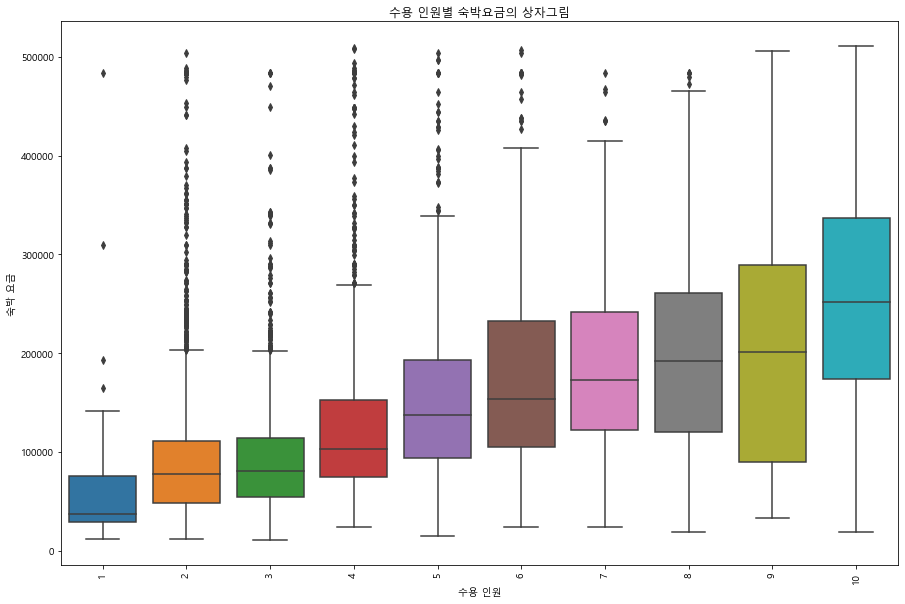

In [377]:
# 수용 인원별 숙박요금의 상자그림
plt.figure(figsize=(15,10))
ax = sns.boxplot(y= "price", x = "accommodates",  data = df)
ax.set(xlabel='수용 인원', ylabel='숙박 요금')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_title("수용 인원별 숙박요금의 상자그림")
plt.show()

In [378]:
# 등분산 검정 실시
accommodates_list = list(df["accommodates"].value_counts().index)
data_ = [df.loc[df["accommodates"] == accommodates, "price"].values for accommodates in accommodates_list]
stats.levene(*data_)
# 등분산검정의 귀무가설을 기각한다. 등분산이 아니다.

LeveneResult(statistic=81.16359405316359, pvalue=7.344383145428568e-146)

In [379]:
# welch_anova
import pingouin as pg
pg.welch_anova(dv='price', between='accommodates', data=df)

,Source,ddof1,ddof2,F,p-unc,np2
0,accommodates,9,1670.459006,381.124251,0.0,0.27235


In [401]:
# 독립표본 T검정을 시각화와 함께 실시하는 함수
def check_binclass(col, df):
    sns.boxplot(x = col, y = "price", data=df)
    a = df[df[col]==df[col].value_counts().index[0]]["price"]
    b = df[df[col]==df[col].value_counts().index[1]]["price"]
    if stats.levene(a,b)[1] < 0.05:
        p_val = stats.ttest_ind(a,b,equal_var = False)[1]
        print("이분산")
    else :
        p_val = stats.ttest_ind(a,b,equal_var = True)[1]
        print("등분산")
    if p_val < 0.05:
        print( f"유의확률이 {round(p_val,4)}이므로 "+col+"에 따른 숙박요금의 평균의 차이는 있다")
    else:
        print( f"유의확률이 {round(p_val,4)}이므로 "+col+"에 따른 숙박요금의 평균의 차이는 없다")
        return col

이분산
유의확률이 0.0이므로 tv에 따른 숙박요금의 평균의 차이는 있다


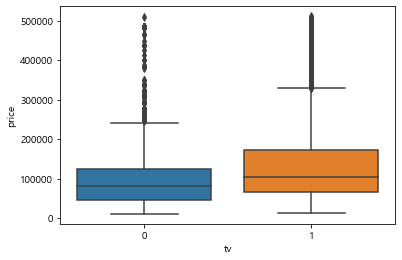

In [402]:
check_binclass("tv", df)

이분산
유의확률이 0.077이므로 wifi에 따른 숙박요금의 평균의 차이는 없다


'wifi'

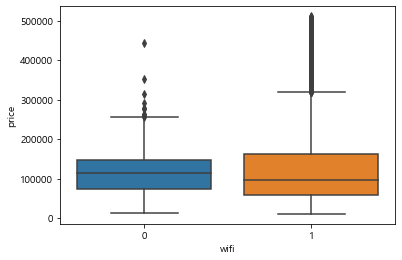

In [403]:
check_binclass("wifi", df)

등분산
유의확률이 0.9603이므로 refrigerator에 따른 숙박요금의 평균의 차이는 없다


'refrigerator'

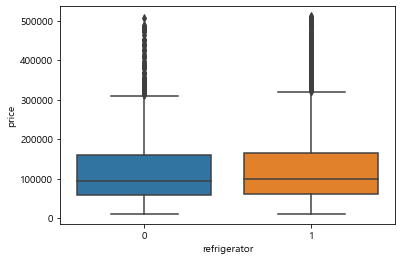

In [404]:
check_binclass('refrigerator', df)

이분산
유의확률이 0.1237이므로 dryer에 따른 숙박요금의 평균의 차이는 없다


'dryer'

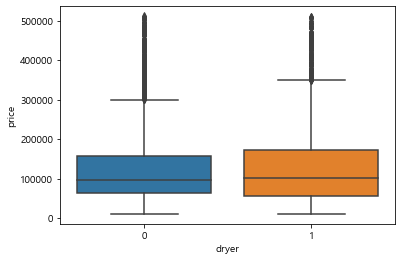

In [405]:
check_binclass('dryer', df)

이분산
유의확률이 0.0이므로 shared_bathrooms에 따른 숙박요금의 평균의 차이는 있다


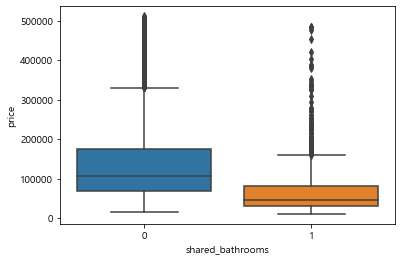

In [406]:
check_binclass('shared_bathrooms', df)

In [414]:
len(df.loc[(df["neighbourhood_cleansed"] == "S")&(df["tv"] == 1)&(df["shared_bathrooms"] == 0)&(df["accommodates"] == 10)]["price"])

0

In [456]:
def is_outlier(neighbourhood_cleansed, tv, shared_bathrooms, accommodates, price):
    sample = df.loc[
        (df["neighbourhood_cleansed"] == neighbourhood_cleansed)&
        (df["tv"] == tv)&
        (df["shared_bathrooms"] == shared_bathrooms)&
        (df["accommodates"] == accommodates)
    ]["price"]
    if len(sample) < 2:
        raise Exception("해당 조건에 맞는 표본의 수가 부족합니다")  
    else:
        return stats.ttest_1samp(sample, price)[1]                
is_outlier("Shibuya Ku", tv=1, shared_bathrooms=0, accommodates=4, price=158300)

0.9943387858746022

In [457]:
is_outlier("Shibuya Ku", tv=1, shared_bathrooms=0, accommodates=4, price=140000)

0.023740959719747975